In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bikesharing/hour.csv


In [2]:
import pandas as pd
path_to_csv="/kaggle/input/bikesharing/hour.csv"
hourly_data=pd.read_csv(path_to_csv)

# 1. Data Pre-Processing

In [3]:
# Filter 'casual' outliers
Q1_casual = hourly_data['casual'].quantile(0.25)
Q3_casual = hourly_data['casual'].quantile(0.75)
IQR_casual = Q3_casual - Q1_casual
lower_bound_casual = Q1_casual - 1.5 * IQR_casual
upper_bound_casual = Q3_casual + 1.5 * IQR_casual
filtered_hourly_data = hourly_data[(hourly_data['casual'] >= lower_bound_casual) & (hourly_data['casual'] <= upper_bound_casual)]

# Filter 'registered' outliers
Q1_registered = filtered_hourly_data['registered'].quantile(0.25)
Q3_registered = filtered_hourly_data['registered'].quantile(0.75)
IQR_registered = Q3_registered - Q1_registered
lower_bound_registered = Q1_registered - 1.5 * IQR_registered
upper_bound_registered = Q3_registered + 1.5 * IQR_registered
filtered_hourly_data = filtered_hourly_data[(filtered_hourly_data['registered'] >= lower_bound_registered) & (filtered_hourly_data['registered'] <= upper_bound_registered)]


# 2. Feature Selection

In [4]:
import numpy as np
from sklearn.model_selection import GridSearchCV,train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

predictors=['season', 'mnth', 'hr', 'holiday', 'weekday','workingday', 'weathersit', 'temp', 'hum', 'windspeed']

# Removed features which were not required
X=filtered_hourly_data[predictors]
y=filtered_hourly_data['cnt']

# 3. Train Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Training & Hyperparameter optimization - XG Boost Regressor

In [6]:
# Parameter grid for hyperparameter optimization - only final results in place currently
param_grid = {
    'n_estimators': [4000],
    'learning_rate': [0.1]
}

# Instantiate the XGBoost regressor
xgb_regressor = XGBRegressor()

# Define the K-fold cross validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=kfold,verbose=2)

# Fit the grid search to the data, taking log+1 of y_train to normalize it
grid_search.fit(X_train, np.log1p(y_train))

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...............learning_rate=0.1, n_estimators=4000; total time=  23.4s
[CV] END ...............learning_rate=0.1, n_estimators=4000; total time=  22.0s
[CV] END ...............learning_rate=0.1, n_estimators=4000; total time=  21.7s
[CV] END ...............learning_rate=0.1, n_estimators=4000; total time=  20.3s
[CV] END ...............learning_rate=0.1, n_estimators=4000; total time=  21.9s
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 4000}
Best cross-validation score: 0.2791440106931539


# 5. Evaluation on Test Set

In [7]:
from sklearn.metrics import mean_absolute_error, r2_score

# Get the best estimator
best_model = grid_search.best_estimator_

# Predict on the test set & converting it back by taking e^x -1
y_pred = np.expm1(best_model.predict(X_test))

# Calculate MAE and R2
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"R²: {r2}")

MAE: 28.541862965224226
R²: 0.8720714555093328


<Figure size 1000x800 with 0 Axes>

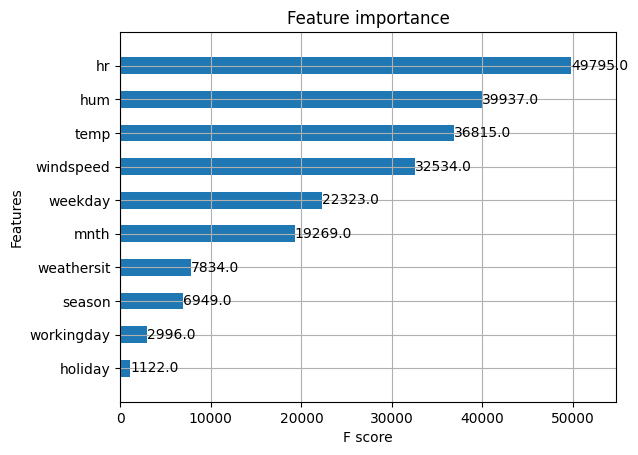

In [8]:
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_model, height=0.5)
plt.savefig('xgb_feature_importance.png', bbox_inches='tight')

plt.show()

# 6. SHAP Explainer using Test Set

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


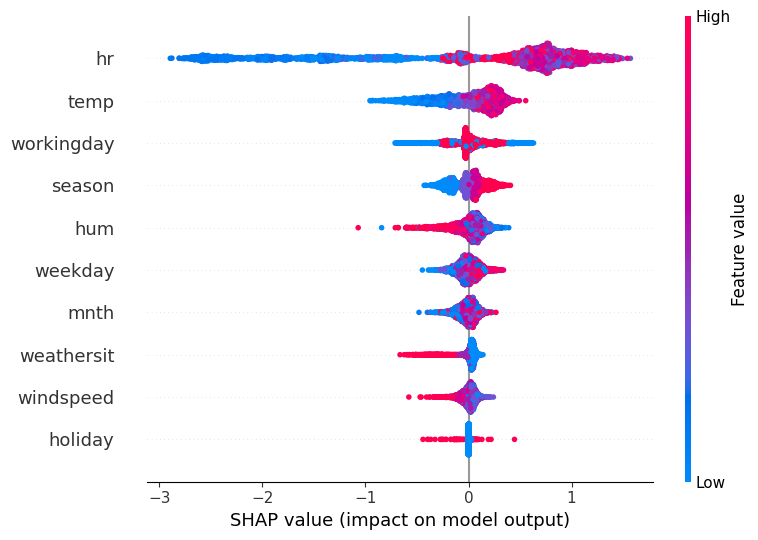

In [9]:
import shap
import matplotlib.pyplot as plt
# Create the SHAP Explainer
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

plt.figure()
shap.summary_plot(shap_values, X_test)